# Adversarial domain adaptation in Tensorflow 2.0
- TF2 implementation of basic adversarial technique documented here: https://arxiv.org/pdf/1409.7495.pdf
- Source: MNIST 
- Target: MNIST-M (MNIST with random colour patches)
- Train on MNIST and test on MNIST-M
- Make the features of the classifier invariant to the domain to boost performance
- Gives performance boost in accuracy on target domain from ~60% to ~84%

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.python.keras import Model
import imageio
import pandas as pd
import numpy as np
import IPython.display as display
import os
import pickle

In [3]:
print("GPU Available: ", tf.test.is_gpu_available())
print(tf.__version__)

GPU Available:  True
2.0.0


In [3]:
LOAD_FROM_PICKLE = False # True if ./mnist_m/mnist_m_test_ls.pkl and ./mnist_m/mnist_m_train_ls.pkl files present

## Baseline on MNIST-M

Import MNIST and convert to RGB by replicating across 3 dimensions

In [0]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.stack((x_train,)*3, axis=-1)
x_test = np.stack((x_test,)*3, axis=-1)

Form a TF dataset

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(60000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

test_ds

<BatchDataset shapes: ((None, 28, 28, 3), (None,)), types: (tf.uint8, tf.uint8)>

Now MNIST-M: dataset can be obtained here: https://drive.google.com/drive/folders/0B_tExHiYS-0vR2dNZEU4NGlSSW8.
Use imageio to read the images and crop to 28 by 28, then create a second tf dataset 

In [4]:
if not LOAD_FROM_PICKLE:
    mnist_m_train_folder = './mnist_m/mnist_m_train/'
    sorted_img_paths_train = [mnist_m_train_folder + i for i in sorted(os.listdir(mnist_m_train_folder))]
    
    mnist_m_test_folder = './mnist_m/mnist_m_test/'
    sorted_img_paths_test = [mnist_m_test_folder + i for i in sorted(os.listdir(mnist_m_test_folder))]

In [0]:
mnist_m_train_labels_file = './mnist_m/mnist_m_train_labels.txt'
with open(mnist_m_train_labels_file, "r") as f:
  mnist_m_train_y = [int(i[-1]) for i in f.read().split('\n')[:-1]]

mnist_m_test_labels_file = './mnist_m/mnist_m_test_labels.txt'
with open(mnist_m_test_labels_file, "r") as f:
  mnist_m_test_y = [int(i[-1]) for i in f.read().split('\n')[:-1]]

In [0]:
if LOAD_FROM_PICKLE:
    with open("./mnist_m/mnist_m_train_ls.pkl", 'rb') as f:
      mnist_m_train_ls = pickle.load(f)
    with open("./mnist_m/mnist_m_test_ls.pkl", 'rb') as f:
      mnist_m_test_ls = pickle.load(f)
else:
    mnist_m_train_ls = [(imageio.imread(i)[2:-2,2:-2,:]) for i in sorted_img_paths_train]
    with open("./mnist_m/mnist_m_train_ls.pkl", 'wb') as f:
      pickle.dump(mnist_m_train_ls, f)
    mnist_m_test_ls = [(imageio.imread(i)[2:-2,2:-2,:]) for i in sorted_img_paths_test]
    with open("./mnist_m/mnist_m_test_ls.pkl", 'wb') as f:
      pickle.dump(mnist_m_test_ls, f)

In [0]:
mnist_m_train_ds = tf.data.Dataset.from_tensor_slices((mnist_m_train_ls,tf.cast(mnist_m_train_y, tf.int8))).batch(32)


In [0]:
mnist_m_test_ds = tf.data.Dataset.from_tensor_slices((mnist_m_test_ls,tf.cast(mnist_m_test_y, tf.int8))).batch(32)

Check some images

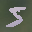

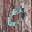

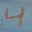

In [5]:
if not LOAD_FROM_PICKLE:
    for n in range(3):
      image_path = sorted_img_paths_train[n]
      display.display(display.Image(image_path))
      print()

Combine MNIST and MNIST-M images, to get the channel stats for normalisation

In [0]:
all_train_domain_images = np.vstack((x_train, mnist_m_train_ls))
channel_mean = all_train_domain_images.mean((0,1,2))

In [0]:
class BaselineModel(Model):
  def __init__(self):
    super(BaselineModel, self).__init__()
    
    self.normalise = lambda x: (tf.cast(x, tf.float64) - channel_mean) / 255.0
    self.conv1 = Conv2D(64, 5, activation='relu')
    self.conv2 = Conv2D(128, 5, activation='relu')
    self.maxpool = MaxPool2D(2)
    self.flatten = Flatten()
    
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation='softmax')
    

  def call(self, x):
    x = self.normalise(x)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.maxpool(x)
    x = self.flatten(x)
    x = self.d1(x)

    return self.d2(x)

model = BaselineModel()

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

Need a separate loss accumulator for each train/test dataset

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

m_test_loss = tf.keras.metrics.Mean(name='test_loss')
m_test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

Train and test ops

In [0]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [0]:
@tf.function
def test_step(mnist_images, labels, mnist_m_images, labels2):
  predictions = model(mnist_images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

  predictions = model(mnist_m_images)
  t_loss = loss_object(labels2, predictions)
    
  m_test_loss(t_loss)
  m_test_accuracy(labels2, predictions)

In [0]:
def reset_metrics():
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    m_test_loss.reset_states()
    m_test_accuracy.reset_states()

Train on MNIST, evaluate on MNIST and MNIST-M

In [72]:
EPOCHS = 100

for epoch in range(EPOCHS):
  reset_metrics()
  for images, labels in train_ds:
    train_step(images, labels)

  for test_data, m_test_data in zip(test_ds,mnist_m_test_ds):
    test_step(test_data[0], test_data[1], m_test_data[0], m_test_data[1])
    
  template = 'Epoch {}, Train Accuracy: {}, Source Test Accuracy: {}, Target Test Accuracy: {}'
  print (template.format(epoch+1,
                         train_accuracy.result()*100,
                         test_accuracy.result()*100,
                         m_test_accuracy.result()*100,))



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Train Accuracy: 97.06166076660156, Source Test Accuracy: 98.67021179199219, Target Test Accuracy: 57.649147033691406
Epoch 2, Train Accuracy: 98.88500213623047, Source Test Accuracy: 98.48182678222656, Target Test Accuracy: 58.24908447265625
Epoch 3, Train Accuracy: 99.25167083740234, Source Test Accuracy: 98.891845703125, Target Test Accuracy: 56.715919494628906
Epoch 4, Train Accuracy: 99.52666473388672, Source Test Accuracy: 98.82535552978516, Target Test Accuracy: 59.34895706176758
Epoch 5,

## Domain confusion
Build separate components so that distinct sets of gradients are easily accessed:

- feature generator
- label classifier 
- domain classifier 

In [0]:
class FeatureGenerator(Model):
  def __init__(self):
    super(FeatureGenerator, self).__init__() 
    self.normalise = lambda x: (tf.cast(x, tf.float64) - channel_mean) / 255.0
    self.conv1 = Conv2D(64, 5, activation='relu')
    self.conv2 = Conv2D(128, 5, activation='relu')
    self.maxpool = MaxPool2D(2)
    self.flatten = Flatten()
    
  def call(self, x):
    x = self.normalise(x)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.maxpool(x)

    return self.flatten(x)

feature_generator = FeatureGenerator()

In [0]:
class LabelPredictor(Model):
  def __init__(self):
    super(LabelPredictor, self).__init__() 
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation='softmax')
    

  def call(self, feats):  
    feats = self.d1(feats)

    return self.d2(feats)

label_predictor = LabelPredictor()

In [0]:
class DomainPredictor(Model):
  def __init__(self):
    super(DomainPredictor, self).__init__()   
    self.d3 = Dense(64, activation='relu')
    self.d4 = Dense(2, activation='softmax')

  def call(self, feats):
    feats = self.d3(feats)
    
    return self.d4(feats)

domain_predictor = DomainPredictor()

Make second training dataset of MNIST and MNIST-M images and their respective domains

In [0]:
x_train_domain_labels = np.ones([len(x_train)])
mnist_m_train_domain_labels = np.zeros([len(mnist_m_train_ls)])
all_train_domain_labels = np.hstack((x_train_domain_labels, mnist_m_train_domain_labels))

domain_train_ds = tf.data.Dataset.from_tensor_slices(
    (all_train_domain_images, tf.cast(all_train_domain_labels, tf.int8))).shuffle(60000).batch(32)

Separate optimizers to allow different learning rates

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
f_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

Discriminative losses

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

m_test_loss = tf.keras.metrics.Mean(name='m_test_loss')
m_test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='m_test_accuracy')

Confusion loss

In [0]:
conf_train_loss = tf.keras.metrics.Mean(name='c_train_loss')
conf_train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='c_train_accuracy')

## Adversarial loss

There are three sets of parameters to update, one for each component of the model. Label and domain classifiers are updated in the usual way. Parameters of the feature generator are updated using the standard gradient backpropagated from the label classifier, summed with the reverse of the gradient from the domain classifier; the feature generator learns to confound the domain classifier, resulting in domain invariant features which should be useful for general performance.


<img src="DANN_architecture.png" style="width: 600px;">


Image taken from: https://arxiv.org/pdf/1409.7495.pdf

In [0]:
@tf.function
def train_step(images, labels, images2, domains, alpha):
    
  """
  i. images = batch of source images
  ii. labels = corresponding labels
  iii. images2 = batch of source and target images
  iv. domains = corresponding domain labels
  v. alpha = weight attributed to the domain loss
  """
    
  ## Update the generator and the classifier
  with tf.GradientTape(persistent=True) as tape:
    features = feature_generator(images)
    l_predictions = label_predictor(features)
    features = feature_generator(images2)
    d_predictions = domain_predictor(features)
    label_loss = loss_object(labels, l_predictions)
    domain_loss = loss_object(domains, d_predictions)
    
  f_gradients_on_label_loss = tape.gradient(label_loss, feature_generator.trainable_variables)
  f_gradients_on_domain_loss = tape.gradient(domain_loss, feature_generator.trainable_variables)    
  f_gradients = [f_gradients_on_label_loss[i] - alpha*f_gradients_on_domain_loss[
      i] for i in range(len(f_gradients_on_domain_loss))]

    
  l_gradients = tape.gradient(label_loss, label_predictor.trainable_variables)

  f_optimizer.apply_gradients(zip(f_gradients+l_gradients, 
                                  feature_generator.trainable_variables+label_predictor.trainable_variables)) 
    
    
  ## Update the discriminator: Comment this bit to complete all updates in one step. Asynchronous updating 
  ## seems to work a bit better, with better accuracy and stability, but may take longer to train    
  with tf.GradientTape() as tape:
    features = feature_generator(images2)
    d_predictions = domain_predictor(features)
    domain_loss = loss_object(domains, d_predictions)
  #####
   
  d_gradients = tape.gradient(domain_loss, domain_predictor.trainable_variables)  
  d_gradients = [alpha*i for i in d_gradients]
  d_optimizer.apply_gradients(zip(d_gradients, domain_predictor.trainable_variables))
  
    
    
  train_loss(label_loss)
  train_accuracy(labels, l_predictions)
  conf_train_loss(domain_loss)
  conf_train_accuracy(domains, d_predictions)

In [0]:
@tf.function
def test_step(mnist_images, labels, mnist_m_images, labels2):
  features = feature_generator(mnist_images)
  predictions = label_predictor(features)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

  features = feature_generator(mnist_m_images)
  predictions = label_predictor(features)
  t_loss = loss_object(labels2, predictions)
    
  m_test_loss(t_loss)
  m_test_accuracy(labels2, predictions)

In [0]:
def reset_metrics():
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    m_test_loss.reset_states()
    m_test_accuracy.reset_states()

Train and evaluate. May need > 100 epochs for convergence

In [57]:
EPOCHS = 100

alpha = 1
for epoch in range(EPOCHS):
  reset_metrics()
  
  for domain_data, label_data in zip(domain_train_ds, train_ds):
    
    try:
      train_step(label_data[0], label_data[1], domain_data[0], domain_data[1], alpha=alpha)
     
    #End of the smaller dataset
    except ValueError: 
      pass
    
  for test_data, m_test_data in zip(test_ds,mnist_m_test_ds):
    test_step(test_data[0], test_data[1], m_test_data[0], m_test_data[1])
  
  template = 'Epoch {}, Train Accuracy: {}, Domain Accuracy: {}, Source Test Accuracy: {}, Target Test Accuracy: {}'
  print (template.format(epoch+1,
                         train_accuracy.result()*100,
                         conf_train_accuracy.result()*100,
                         test_accuracy.result()*100,
                         m_test_accuracy.result()*100,))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Train Accuracy: 85.02667236328125, Domain Accuracy: 76.75167083740234, Source Test Accuracy: 94.37056732177734, Target Test Accuracy: 48.861236572265625
Epoch 2, Train Accuracy: 96.3516616821289, Domain Accuracy: 71.64749908447266, Source Test Accuracy: 97.30718231201172, Target Test Accuracy: 53.694034576416016
Epoch 3, Train Accuracy: 96.4383316040039, Domain Accuracy: 69.13944244384766, Source Test Accuracy: 97.4401626586914, Target Test Accuracy: 57.8713493347168
Epoch 4, Train Accuracy: 96